## Final Assignment

In [178]:
# The Python modules you need for thisn assignment.
import pandas as pd
import os.path
import urllib.request 
import os.path
from matplotlib import pyplot as plt

url_dir = 'https://gawron.sdsu.edu/python_for_ss/course_core/data'

Loading and applying the style sheets in the next two cells customizes the styles of your notebook output,
in particular for how pandas `DataFrame`s are printed.

This is optional,  but it's interesting if you know anything about css files.

In [179]:
target_url1 = os.path.join(url_dir,'style-notebook.css')
target_url2 = os.path.join(url_dir,'style-table.css')

with urllib.request.urlopen(target_url1) as fh1:
    css1 = fh1.read().decode('utf8')
with urllib.request.urlopen(target_url2) as fh2:
    css2 = fh2.read().decode('utf8')
css = css1 + css2

In [180]:
from IPython.core.display import HTML
#css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

The next cell loads the `titles` DataFrame, the first of two used in this assignment.  There are only
two columns, `'title'`  and `'year'`.

In [230]:
titles = pd.read_csv(os.path.join(url_dir,'titles.csv'))
titles.head()

,title,year
0,The Patriarchs,2009
1,Angels in the Attic,1998
2,The Rapture,1991
3,Star na si Van Damme Stallone,2016
4,Sweet Talk,2004


The next cell loads the `cast` DataFrame, the second of two used in this assignment.  This is
large and will take a while.

In [182]:
# This is much larger and wont work in google colab at the moment
#cast = pd.read_csv(os.path.join(url_dir,'cast.csv'),index_col=0)
cast = pd.read_csv(os.path.join(url_dir,'truncated_cast.csv'),index_col=0)
cast.head()

,title,year,name,type,character,n
49,In the Land of the Head Hunters,1914,Paddy 'Malid,actor,Kenada,5.0
80,The Colour of Darkness,2016,Ketan Daraji -Gohel,actor,Chhagan,NaN
81,London Betty,2009,Isaiah Entsua -Mensah,actor,Camera Man,NaN
82,Candelabra,2014,Groovin .,actor,Lt. Dick Sims,5.0
83,Bad Ideas,2012,Hamid .,actor,The Diner,NaN


## Creating the actor graph

Steps

0.  Create a subDataFrame of `cast` (call it `cast0`) with only the rows whose value in the `n` column is less than 10 (we are going to restrict our attention to the most important roles in each film).

   ```
   Cast: 422,837      Cast0: 192,307
   ```

1.  Group the rows of `cast0` so that each group is a film, where a film is a pair of title and a year (remember that movies like *Ben Hur* have been made more than once).

   ```
   Number of groups = Number of films = 43,853
   ```
2.  Create a `networkx` graph (Call it `G`) using the `groupby` object from step 1, where each node is an actor and there is an edge between two nodes if and only if the two actors were cast in the same film (according to `cast0`). 

   ```
   len(G) = 36,774 len(G.edges) = 511,762
   ```
   
   Hint: Start with an empty non directed `Graph` instance `G = nx.Graph()`.  You can build a graph
   entirely by adding edges. (the corresponding nodes will automatically be added).
   
   Hint:  You really only care about the `name` column in each group, so convert your `GroupBy` instance
   `gb` into a `SeriesGroupBy` instance by doing `gb["name"]`.  You can loop through a `SeriesGroupBy` instance 
     
     ```
     for xx in gb["name"]:
     ```
     
   and each `xx` will correspond to a group (a film). You should be able to take an `xx` apart and use the
   information to add edges to `G`.  You will probably fiond the `.add_edges_from(...)` method useful.

#### Step 0

In [183]:
len(cast)

422837

In [184]:
## Your code in the line below
cast0 =  cast[cast['n'] < 10]  ## Add a value  cast[cast['n'] < 10]
print(f"Cast: {len(cast):,}      Cast0: {len(cast0):,}")

Cast: 422,837      Cast0: 192,307


####  Step 1

In [185]:
# Create the groupby object using cast0  RememberA film is a pair of  title and a year
cg =   cast0.groupby(['title','year'])['name']     ## Add a value cast0.groupby(['title','year'])['name']

In [186]:
len(cg)

43853

In [187]:
type(cg)

pandas.core.groupby.generic.SeriesGroupBy

#### Getting a group/Looping through the groups

In the following cells `cg` is a `SeriesGroupBy` instance where each group corresponds to a film
(a title, year pair).

In [188]:
# I didn't know what year 'Bringing Up Baby' was made so I had to do this
cg1 = [(t,y) for (t,y) in cg.groups if t=='Bringing Up Baby'][0]
# Any particular group fetched is a Series containing the cast of one film
cg1_ser = cg.get_group(cg1)

This is the 9 most important members of the cast of "Bringing Up Baby" (in no particular order) as an array of strings.

In [189]:
cg1_ser

339187        Walter Catlett
650147            Fritz Feld
670773      Barry Fitzgerald
797118            Cary Grant
978604         George Irving
1810038      Charles Ruggles
2751791    Katharine Hepburn
3172772        Leona Roberts
3175356           May Robson
Name: name, dtype: object

In [190]:
cg1_ser.iloc[2:10].values

array(['Barry Fitzgerald', 'Cary Grant', 'George Irving',
       'Charles Ruggles', 'Katharine Hepburn', 'Leona Roberts',
       'May Robson'], dtype=object)

Looping through a `SeriesGroupBy` instance:

In [191]:
for g in  cg:
    print(len(g))
    print(g[0])
    print(type(g[1]))
    break

2
('#REALITYHIGH', 2017)
<class 'pandas.core.series.Series'>


#### Step 2 Making the actor graph

In [192]:
import networkx as nx
G = nx.Graph()
for (film, g_ser) in cg:
    for (i,name) in enumerate(g_ser):
        G.add_edges_from([(name,name2) for name2 in g_ser.iloc[i+1:]])

###  Answer the following questions

Be sure to verify each answer with a code snippet.

###  How many nodes does G have?

In [193]:
len(G)

36774

### How many edges does G have?

In [194]:
len(G.edges)

511762

### How many actors is Barry Fitzgerald connected to in `G`?  How many actors is Cary Grant connected to?

In [197]:
G.degree('Barry Fitzgerald'),G.degree('Cary Grant')

(62, 239)

###  What are the degree centrality values for Barry Fitzgerald and Cary Grant?

In [198]:
dc = nx.degree_centrality(G)

In [199]:
dc['Barry Fitzgerald'],dc['Cary Grant']

(0.0016860196339705763, 0.0064993337503059315)

### Have Christopher Walken and Cyndi Lauper ever appeared in a film together (according to `G`)?

In [202]:
('Cyndi Lauper','Barry Fitzgerald') in G.edges()

False

### Have Josephine Hutchinson and Cary Grant ever occured in a film together (according to `G`)?

In [201]:
('Josephine Hutchinson','Cary Grant' ) in G.edges()

True

### List the actors with top 100 degree centralities

More specifically, construct a list with just the top 100 actors in the order
of their degree centrality in G from highest to lowest.  To be clear, the list should
**not** include the centrality values.

In [203]:
dc_il = sorted(dc.items(),key=lambda x:x[1],reverse=True)
[act for (act, dc) in dc_il[:100]]

['J. Farrell MacDonald',
 'Raymond Hatton',
 'Noah Beery',
 'Richard Tucker',
 'Tully Marshall',
 'Zasu Pitts',
 'Lucien Littlefield',
 'Alec B. Francis',
 'Jack Mulhall',
 'Joseph W. Girard',
 'Montagu Love',
 'George Fawcett',
 'Alan Hale',
 'Eugene Pallette',
 'Arthur Hoyt',
 'Jack Holt',
 'Hedda Hopper',
 'John Miljan',
 'Robert Frazer',
 'Lafe McKee',
 'Adolphe Menjou',
 'Wade Boteler',
 'Lewis Stone',
 'Hobart Bosworth',
 'Charles K. French',
 'Crauford Kent',
 'Henry B. Walthall',
 'Lois Wilson',
 'Philo McCullough',
 'Wheeler Oakman',
 'Fred Kohler',
 'Holmes Herbert',
 'Jean Hersholt',
 'Monte Blue',
 'Henry Kolker',
 'Buck Jones',
 'Harry Carey',
 "Guinn 'Big Boy' Williams",
 'Betty Compson',
 'William V. Mong',
 'Kenneth Harlan',
 'Walter McGrail',
 'Josef Swickard',
 'Wallace Beery',
 'Bryant Washburn',
 'William B. Davidson',
 'Russell Simpson',
 'Theodore von Eltz',
 'Gertrude Astor',
 'Walter Miller',
 'Conrad Nagel',
 'Edmund Lowe',
 'Huntley Gordon',
 'DeWitt Jennings'

### List the actors with top 100 Katz Centralities (in the same way as in the previous question)

Note:  If you do this right, it should take quite a bit longer than the previous question.

In [152]:
import time
kc = nx.katz_centrality(G)
kc_il = sorted(kc.items(),key=lambda x:x[1],reverse=True)
print(time.asctime( time.localtime(time.time()) ))
[act for (act, kc) in kc_il[:100]]
print(time.asctime( time.localtime(time.time()) ))

KeyboardInterrupt: 

### Using groupby(), plot the number of films that have been released each decade using all films made in or before 2022

<AxesSubplot:xlabel='decade'>

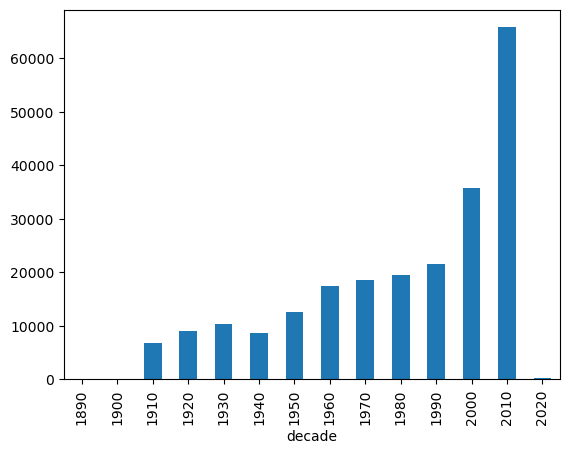

In [235]:
titles['decade'] = 10*(titles['year']//10)
tg=titles[titles['year']<2022].groupby('decade').count()
tg['title'].plot(kind='bar')

In [233]:
titles['decade']

0         2009
1         1998
2         1991
3         2016
4         2004
          ... 
226008    2018
226009    2017
226010    2010
226011    2009
226012    2001
Name: decade, Length: 226013, dtype: int64

### Use groupby() to plot the number of "Hamlet" films made each decade.

Solution without adding another column.  Use a groupby function.

In [236]:
#hamlet_by_decades = titles[titles['title']=='Hamlet'].groupby(lambda i: 10*(titles.loc[i].year//10))
hamlet_by_decades = titles[titles['title']=='Hamlet'].groupby(10*(titles.year//10)).count()

In [172]:
titles['decade'] = 10*(titles.year//10)
hamlet_by_decades2 = titles[titles['title']=='Hamlet'].groupby('decade').count()

In [209]:
hamlet_by_decades

,title,year
year,,
1910,3,3
1920,1,1
1940,1,1
1950,1,1
1960,2,2
1970,2,2
1980,1,1
1990,2,2
2000,2,2


<AxesSubplot:xlabel='year'>

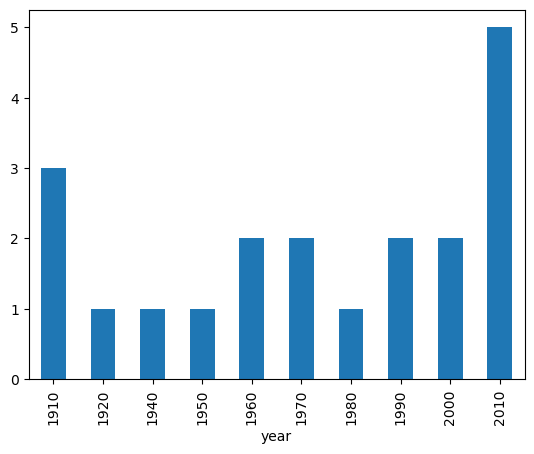

In [237]:
hamlet_by_decades['year'].plot(kind='bar')

### How many leading (n=1) roles were available to actors, and how many to actresses, in each year of the 1950s?

### In the 1950s decade taken as a whole, how many total roles were available to actors, and how many to actresses, for each "n" number 1 through 5?

### Use groupby() to determine how many roles are listed for each of the Pink Panther movies.

### List, in order by year, each of the films in which Frank Oz has played more than 1 role.

### List each of the characters that Frank Oz has portrayed at least twice.